# Machine Learning

In [1]:
import pandas as pd 
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import r2_score, accuracy_score

import plotly.express as px 

### Importing dataframe

In [2]:
df_init = pd.read_parquet("data/base.parquet", engine="pyarrow")

In [3]:
df = df_init.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45025 entries, 0 to 67409
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SEASON        45025 non-null  object 
 1   BASIN         45025 non-null  object 
 2   NATURE        45025 non-null  object 
 3   LAT           45025 non-null  float64
 4   LON           45025 non-null  float64
 5   WIND          45025 non-null  float64
 6   DIST2LAND     45025 non-null  float64
 7   STORM_SPEED   45025 non-null  float64
 8   STORM_DIR     45025 non-null  float64
 9   TD9636_STAGE  45025 non-null  float64
dtypes: float64(7), object(3)
memory usage: 3.8+ MB


## Model

### Encoding

The dataframe has been cleaned and only the relevant columns remain, however we need to process the colones further. 

Categorical => OneHotEncoder or one dimension with different values (1, 2, 3, 4, etc.)
- SEASON (4 classes)
- BASIN (7 classes)
- NATURE (6 classes)

Numeric => everything between 0 and 1
- LAT
- LON
- WIND 
- DIST2LAND
- STORM_SPEED
- STORM_DIR

In this notebook we will create personalized values in the categorical columns if possible to limit the dimensions to add

## First models 

We are starting by testing multiple Machine Learning models on a cleaned simplified dataset.

Categorical => OneHotEncoder or one dimension with different values (1, 2, 3, 4, etc.)
- SEASON (4 classes)
- BASIN (7 classes)
- NATURE (6 classes)

Numeric => everything between 0 and 1
- LAT
- LON
- WIND 
- DIST2LAND
- STORM_SPEED
- STORM_DIR

### Choosing the pertient models

The different models can be found here :
https://scikit-learn.org/stable/machine_learning_map.html

| model | person | scores | encoding
| --- | --- | --- | --- | 
| Knn | Vincent | -- | OneHotEncoder/LabelBinarizer | 
| Knn | -- | -- | -- | 
| SVM | Vincent | -- | OneHotEncoder/LabelBinarizer | 
| SVM | -- | -- | -- | 
| Randomforest | Audrey | -- | OneHotEncoder/LabelBinarizer | 
| Randomforest | Audrey | -- | Categorical encoding | 
| LinearSVC | Arnaud | -- | OneHotEncoder/LabelBinarizer | 
| LinearSVC | Arnaud | -- | Categorical encoding | 
| -- | -- | -- | -- | 
| -- | -- | -- | -- | 
| -- | -- | -- | -- | 
| -- | -- | -- | -- | 
| -- | -- | -- | -- | 



## Model

### Encoding

The dataframe has been cleaned and only the relevant columns remain, however we need to process the colones further. 

Categorical => OneHotEncoder or one dimension with different values (1, 2, 3, 4, etc.)
- SEASON (4 classes)
- BASIN (7 classes)
- NATURE (6 classes)

Numeric => everything between 0 and 1
- LAT
- LON
- WIND 
- DIST2LAND
- STORM_SPEED
- STORM_DIR

In this notebook we will create personalized values in the categorical columns if possible to limit the dimensions to add

#### Categorical Columns

1. Seasons

In [5]:
def transorm_seasons_1(row):
    match row["SEASON"]:
        case "Winter":
            return 1
        case "Spring":
            return 0
        case "Summer":
            return -1
        case "Fall":
            return 0

def transorm_seasons_2(row):
    match row["SEASON"]:
        case "Winter":
            return 0
        case "Spring":
            return -1
        case "Summer":
            return 0
        case "Fall":
            return 1    


In [6]:
df["SEASON_1"] = df.apply(transorm_seasons_1, axis=1)
df["SEASON_2"] = df.apply(transorm_seasons_2, axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45025 entries, 0 to 67409
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SEASON        45025 non-null  object 
 1   BASIN         45025 non-null  object 
 2   NATURE        45025 non-null  object 
 3   LAT           45025 non-null  float64
 4   LON           45025 non-null  float64
 5   WIND          45025 non-null  float64
 6   DIST2LAND     45025 non-null  float64
 7   STORM_SPEED   45025 non-null  float64
 8   STORM_DIR     45025 non-null  float64
 9   TD9636_STAGE  45025 non-null  float64
 10  SEASON_1      45025 non-null  int64  
 11  SEASON_2      45025 non-null  int64  
dtypes: float64(7), int64(2), object(3)
memory usage: 4.5+ MB


In [8]:
df = df.drop(columns=['SEASON'])

2. Basin

In [9]:
df.BASIN.unique()

array(['SP', 'SI', 'WP', 'EP', 'NI'], dtype=object)

The BASIN categories can not be scored wich is why we use pd.get_dummies() to process the this string data

In [10]:
df = pd.get_dummies(df, columns=["BASIN"], drop_first=True)

In [11]:
df.head(3)

,NATURE,LAT,LON,WIND,DIST2LAND,STORM_SPEED,STORM_DIR,TD9636_STAGE,SEASON_1,SEASON_2,BASIN_NI,BASIN_SI,BASIN_SP,BASIN_WP
0,TS,-12.5,172.5,25.0,647.0,6.0,350.0,1.0,-1,0,False,False,True,False
1,TS,-12.2,172.4,25.0,653.0,6.0,350.0,1.0,-1,0,False,False,True,False
2,TS,-11.9,172.4,25.0,670.0,5.0,360.0,1.0,-1,0,False,False,True,False


3. Nature

We are sorting the NATURE categoriesthem to reflect a progression from the least informative or severe to the most complex or severe nature of cyclones.

0- NR - Not reported: This class indicates that the nature of the cyclone is not reported, so it can be considered the least informative.

1- DS - Disturbance: This class indicates a minor disturbance, which is typically the least severe form of a cyclone.

2- SS - Subtropical: Subtropical cyclones are more organized than disturbances but less severe than tropical cyclones.

3- TS - Tropical: Tropical cyclones are fully developed and more severe than subtropical cyclones.

4- ET - Extratropical: Extratropical cyclones are typically associated with frontal systems and can be very severe.

5- MX - Mixture: This class indicates contradicting nature reports from different agencies, suggesting a complex or uncertain nature, which can be considered the most severe or complex category.

In [12]:
def transorm_nature(row):
    match row["NATURE"]:
        case "NR":
            return 0
        case "DS":
            return 1
        case "SS":
            return 2
        case "TS":
            return 3
        case "ET":
            return 4
        case "MX":
            return 5

In [13]:
df["NATURE_1"] = df.apply(transorm_nature, axis=1)

In [14]:
df = df.drop(columns=['NATURE'])
df.rename(columns={"NATURE_1": "NATURE"}, inplace=True)

### Model Testing

Importing models to test

Logistic Regression can be use as a "base metric" to compare other models performances.

In [271]:
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.model_selection import GridSearchCV

#### Standardizing values

Standardizing the data set for better performence and interpretability by the different models.
Using sklearn built-in preprocessing tools for scaling feat data.

In [272]:
from sklearn import preprocessing

In [273]:
y = df["TD9636_STAGE"]
X = df.copy().drop(columns=['TD9636_STAGE'])

In [274]:
scaler = preprocessing.StandardScaler().fit(X)
scaler

StandardScaler()

In [275]:
X_scaled = scaler.transform(X)

#### Splitting dataset

Spliting the dataset in two half, the feat data and the target data.\
Test feat data size is set to be 80% of the initial data set. `Random_state` is set to 17 for reproductibility.

In [276]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size = 0.2,
    random_state=17)

#### Logistic Regression

Logistic regression main hyperparameters :
- `penalty`: {"l1", "l2", "elasticnet", None}, default="l2"\
    Specify the norm of the penalty:
    - None: no penalty is added;
    - 'l2': add a L2 penalty term and it is the default choice;
    - 'l1': add a L1 penalty term;
    - 'elasticnet': both L1 and L2 penalty terms are added.
- `tol`: float, default=1e-4\
    Tolerance for stopping criteria.stronger regularization.
- `solver`: {‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}, default=’lbfgs’\
    Algorithm to use in the optimization problem. Set to saga as certain solver dosen't handle all penalty.

In [326]:
LogReg = LogisticRegression(random_state=17,
                            max_iter=3000, # Setting a large number of max_iter as Logistic regression is fast to train
                            verbose=0,
                            tol=1e-6,
                            solver="saga",
                            penalty="elasticnet"
                           ) 

In [327]:
parameters = {
    "l1_ratio": [0, 0.5, 1]
}

In [328]:
Grid = GridSearchCV(
    estimator=LogReg,
    param_grid=parameters,
    scoring=["r2", "accuracy"],
    refit="r2",
    verbose=4,
    cv=5
)

In [329]:
Grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END l1_ratio=0; accuracy: (test=0.829) r2: (test=0.702) total time=   3.3s
[CV 2/5] END l1_ratio=0; accuracy: (test=0.834) r2: (test=0.729) total time=   4.2s
[CV 3/5] END l1_ratio=0; accuracy: (test=0.829) r2: (test=0.712) total time=   3.6s
[CV 4/5] END l1_ratio=0; accuracy: (test=0.835) r2: (test=0.702) total time=   4.7s
[CV 5/5] END l1_ratio=0; accuracy: (test=0.836) r2: (test=0.704) total time=   4.0s
[CV 1/5] END l1_ratio=0.5; accuracy: (test=0.830) r2: (test=0.707) total time=  12.7s
[CV 2/5] END l1_ratio=0.5; accuracy: (test=0.833) r2: (test=0.726) total time=  15.4s
[CV 3/5] END l1_ratio=0.5; accuracy: (test=0.828) r2: (test=0.711) total time=  12.6s
[CV 4/5] END l1_ratio=0.5; accuracy: (test=0.835) r2: (test=0.705) total time=  13.7s
[CV 5/5] END l1_ratio=0.5; accuracy: (test=0.837) r2: (test=0.707) total time=  13.3s
[CV 1/5] END l1_ratio=1; accuracy: (test=0.830) r2: (test=0.712) total time=  10.4s
[CV 2/

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=3000, penalty='elasticnet',
                                          random_state=17, solver='saga',
                                          tol=1e-06),
             param_grid={'l1_ratio': [0, 0.5, 1]}, refit='r2',
             scoring=['r2', 'accuracy'], verbose=4)

### Result of the grid search :
As expected, logistic regression are stable from on penalty to another, with a *acceptable* mean accuracy and r2 score.

In [399]:
print(Grid.best_score_,
     Grid.best_params_)

0.9777939131631521 {'l1_ratio': 1}


In [331]:
pd.DataFrame(Grid.cv_results_).sort_values(by='mean_test_r2', ascending=False).head(5).T

,2,1,0
mean_fit_time,13.445418,13.612414,4.05842
std_fit_time,1.617568,1.036476,0.478847
mean_score_time,0.002068,0.00204,0.002086
std_score_time,0.000052,0.000017,0.000021
param_l1_ratio,1.0,0.5,0.0
params,{'l1_ratio': 1},{'l1_ratio': 0.5},{'l1_ratio': 0}
split0_test_r2,0.712211,0.706952,0.702363
split1_test_r2,0.729927,0.726199,0.729067
split2_test_r2,0.716596,0.710867,0.711535
split3_test_r2,0.707847,0.7046,0.701545


In [332]:
y_pred = Grid.predict(X_test)

Interpretation of errors

In [333]:
from sklearn.metrics import accuracy_score, r2_score

In [334]:
from sklearn.metrics import confusion_matrix

First lets take a look at the errors and valid predictions.

In [335]:
print(f"Accuracy: {accuracy_score(y_pred, y_test)}, r2: {r2_score(y_pred, y_test)}")

0.8342032204330927

In [336]:
cm = confusion_matrix(y_pred, y_test)
px.imshow(cm)

C:\Users\PROPRIETAIRE\AppData\Local\Temp\ipykernel_2388\3654850652.py:1: RuntimeWarning:

invalid value encountered in divide



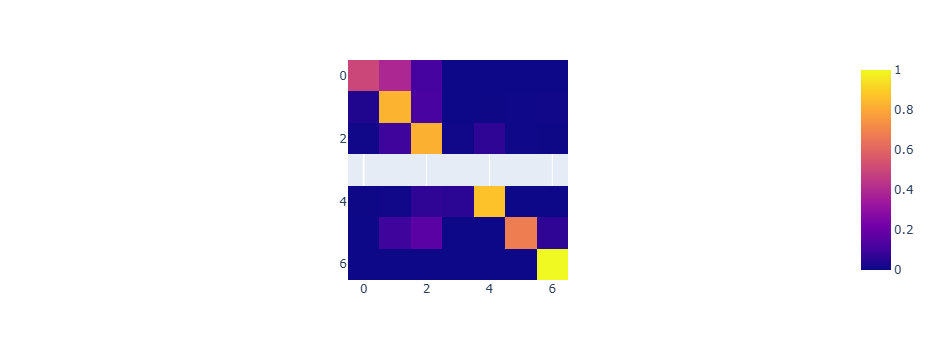

In [337]:
cm = (cm.T / cm.sum(axis=1)).T
px.imshow(cm)

Logistic regression does detect correctly stage 6 cyclones (on a really short sample..) and seems to 'group' stage 0 to 2 cyclones detection as we could expect from a good model. Yet, stage 4 cyclones detection is too messy.\

It could be intresting to see the kind of cyclones we are having error with in stage 4.
Futher more, setting a custom score with ponderated error values could be intresting to sort out a better model.

#### Proposition of custom score (not useful for a logistic regression..)

In [354]:
from sklearn.metrics import make_scorer

In [395]:
def custom_loss_score(y_test, y_pred):

    # Turning y_test and y_pred into numpy ndarrays
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    # initializing variable
    
    error = 0
    ## Creating a "error" weights table
    table = {
        0: 0.2,
        1: 0.5,
        2: 1,
        3: 2,
        4: 3,
        5: 5,
    }
    total_weight = sum(table.values())

    # Calculating the sum of each error value depending on our custom error weights table
    for pos in range(len(y_test)):
        min_ = int(min(y_test[pos], y_pred[pos]))
        max_ = int(max(y_test[pos], y_pred[pos]))
        error += sum([table[i] for i in range(min_, max_) if min_!=max_])/total_weight

    error = error / len(y_test)
    
    return 1 - error

In [396]:
Grid = GridSearchCV(
    estimator=LogReg,
    param_grid=parameters,
    scoring=make_scorer(custom_loss_score, greater_is_better=True),
    refit=True,
    verbose=4,
    cv=5
)

In [397]:
Grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ........................l1_ratio=0;, score=0.977 total time=   3.4s
[CV 2/5] END ........................l1_ratio=0;, score=0.979 total time=   4.2s
[CV 3/5] END ........................l1_ratio=0;, score=0.978 total time=   3.6s
[CV 4/5] END ........................l1_ratio=0;, score=0.977 total time=   4.5s
[CV 5/5] END ........................l1_ratio=0;, score=0.977 total time=   3.9s
[CV 1/5] END ......................l1_ratio=0.5;, score=0.977 total time=  12.6s
[CV 2/5] END ......................l1_ratio=0.5;, score=0.979 total time=  15.3s
[CV 3/5] END ......................l1_ratio=0.5;, score=0.978 total time=  12.8s
[CV 4/5] END ......................l1_ratio=0.5;, score=0.977 total time=  14.2s
[CV 5/5] END ......................l1_ratio=0.5;, score=0.977 total time=  13.7s
[CV 1/5] END ........................l1_ratio=1;, score=0.977 total time=  10.6s
[CV 2/5] END ........................l1_ratio=1;,

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=3000, penalty='elasticnet',
                                          random_state=17, solver='saga',
                                          tol=1e-06),
             param_grid={'l1_ratio': [0, 0.5, 1]},
             scoring=make_scorer(custom_loss_score, response_method='predict'),
             verbose=4)

### Learning Curve

In [ ]:
# Calculate learning curve
learning_curve_ = learning_curve(
    Grid.best_estimator_,
    X_train,
    y_train,
    train_sizes=np.linspace(0.1, 1, 10),
    cv=1,
    verbose=5,
    scoring="r2",
)

In [157]:
train_sizes, train_scores, train_valids = learning_curve_

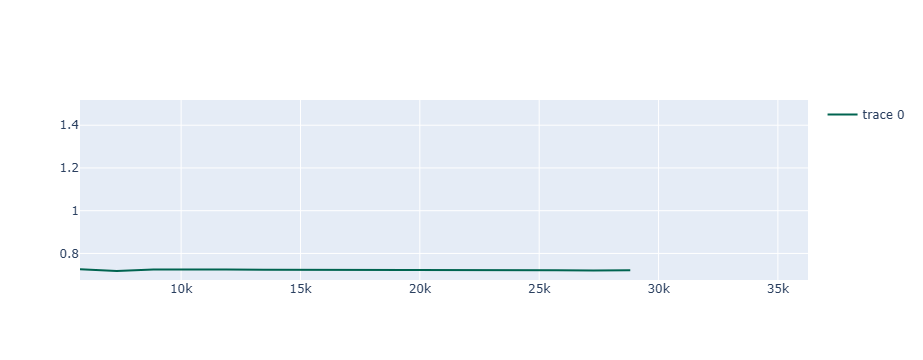

In [158]:
def learning_curve_show(train_sizes, train_scores):
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_max = np.max(train_scores, axis=1)
    train_scores_min = np.min(train_scores, axis=1)
    
    fig = go.Figure([
        go.Scatter(
            x=train_sizes,
            y=train_scores_mean,
            line=dict(color='rgb(0,100,80)'),
            mode='lines'
        ),
        go.Scatter(
            x=train_sizes+train_sizes[::-1], # x, then x reversed
            y=train_scores_max+train_scores_min[::-1], # upper, then lower reversed
            fill='toself',
            fillcolor='rgba(0,100,80,0.2)',
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            showlegend=False
        )
    ])
    fig.show()

learning_curve_show(train_sizes, train_scores)